In [13]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import set_config
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras_tuner.applications import HyperResNet, HyperEfficientNet, HyperXception


from audio_student import AudioUtil, Feature_vector_DS
from model_utils import *
from CNN_utils import *
#from classification.Q2.audio_student import AudioUtil, Feature_vector_DS
#from classification.Q1.model_utils import *
#from classification.Q2.CNN_utils import AudioUtil, Feature_vector_DS


"""
#Pipeline
#-------------------------
1. Dataset import -> get-dataset_matrix()
3. Data preparation -> get_dataset_()
2. Data split -> train_test_split()
3. Data scaling -> StandardScaler()
4. Data processing -> PCA?
5. Modelling -> Tensorflow CNNs (HyperEfficientNet, HyperResNet, HyperDenseNet, 
                HyperXception, HyperMobileNet), self-made)
6. Training and 7. Evaluation -> Tensorflow Keras tuner
8. Final_model -> perform_KFold, fit, predict, accuracy, confusion_matrix, classification_report
#-------------------------

Wanted to use sklearn pipeline but seems too restrictive compared to the benefits
"""
verbose = True


### 1. + 3. + 4. dataset import & preparation & processing

TO MODIFY:
 - All soundfiles must be recorded by the MCU
 - The function Feature_vector_DS must be replaced by the functions in the MCU (in C), it sould have the list of hyperparameters as an input
 - Data augmentation: add background noise augmentation (function already exists!)
  - Potentially concatenate all file from the same class then apply shifting?
 - Conditional normalisation if classes are concatenated?
 - Add possibility to visualize the dataset

Processing: creation of FV from dataset
- Potential PCA
- Time duration


In [14]:
import time

def get_dataset(path="../datasets/sounds/recorded_sounds/classes/",filter_str=None,  Nft=512, nmel=20, duration=950, fs = 10200, normalize=True, shift_pct=0, img_idx = 0, verbose=False, play_sound = False):
    """
    Load and initialize the dataset with necessary attributes.
    """

    # Dataset class containing all sound files
    dataset = Dataset(folder=path, filter_str = filter_str)
    classnames = dataset.list_classes()
    if verbose:
        print("Classes in dataset: ", classnames)
        print("Number of elements in each class: ", dataset.naudio)
        print("Number of sounds in dataset: ", len(dataset))

    myds = Feature_vector_DS(dataset, Nft=Nft, nmel=nmel, duration=duration, fs = fs, shift_pct=shift_pct, normalize=normalize)
    myds.data_aug = None  # Ensure no augmentation initially

    if verbose:
        fig, axs = plt.subplots(1, len(classnames), figsize=(len(classnames) * 4, 3))
        for i, ax in zip(range(len(classnames)), axs):
            ax.imshow(myds[classnames[i], img_idx].reshape((nmel, -1)), cmap="jet", origin="lower", aspect="auto")
            ax.set_title(classnames[i])
            ax.set_xlabel("")
            ax.set_ylabel("Mel bins")
        plt.colorbar(axs[-1].images[0], ax=axs, orientation='vertical')
        plt.show()
        if play_sound:
            for i in range(len(classnames)):
                myds.display([classnames[i], img_idx])
                time.sleep(duration/1000)
    
    return myds, dataset, classnames


import random

def train_test_split(myds: Feature_vector_DS, test_size: float = 0.2, random_seed: int = 42) -> Tuple[Feature_vector_DS, Feature_vector_DS]:
    """
    Splits the dataset into training and testing datasets.

    :param myds: The original Feature_vector_DS dataset.
    :param test_size: The proportion of the dataset to include in the test split (default 0.2, or 20%).
    :param random_seed: The seed for random number generation to ensure reproducibility (default 42).
    
    :return: A tuple of (my_ds_train, my_ds_test) - the training and testing datasets.
    """
    # Set the random seed for reproducibility
    random.seed(random_seed)
    
    # Get the dataset from the Feature_vector_DS object
    dataset = myds.dataset

    # Shuffle the dataset randomly
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    # Calculate the split index
    split_index = int(len(dataset) * (1 - test_size))

    # Split the indices into train and test
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]

    # Create the training and testing datasets using the respective indices
    train_dataset = [dataset[i] for i in train_indices]
    test_dataset = [dataset[i] for i in test_indices]

    # Create new Feature_vector_DS instances for the training and testing datasets
    my_ds_train = Feature_vector_DS(
        train_dataset, 
        Nft=myds.Nft, 
        nmel=myds.nmel, 
        duration=myds.duration, 
        fs=myds.sr,
        shift_pct=myds.shift_pct,
        normalize=myds.normalize,
        data_aug=myds.data_aug,
        pca=myds.pca,
        bg_dataset=myds.bg_dataset,
        bg_amplitude_limit=myds.bg_amplitude_limit,
        noise_sigma=myds.noise_sigma,
        scaling_limit=myds.scaling_limit
    )

    my_ds_test = Feature_vector_DS(
        test_dataset, 
        Nft=myds.Nft, 
        nmel=myds.nmel, 
        duration=myds.duration, 
        fs=myds.sr,
        shift_pct=myds.shift_pct,
        normalize=myds.normalize,
        data_aug=myds.data_aug,
        pca=myds.pca,
        bg_dataset=myds.bg_dataset,
        bg_amplitude_limit=myds.bg_amplitude_limit,
        noise_sigma=myds.noise_sigma,
        scaling_limit=myds.scaling_limit
    )

    return my_ds_train, my_ds_test




def get_picklename(Nft,nmel,duration,fs, augmentations, shift_nb, bg_amplitude_limit, physical_aug, prefix= "../datasets/melvecs/"):
    """
    Generate a unique pickle name based on the augmentations.
    """
    # Generate a unique pickle name based on the augmentations
    pickle_name = prefix

    if len(augmentations) !=0:
        pickle_name+= 'augmented/'
    
    pickle_name += f"melvecs_{Nft}_{nmel}_{duration}_{fs}"
    for aug in augmentations:
        print(aug)
        pickle_name += f"_{aug}"
        if aug == "time_shift":
            pickle_name += f"_{shift_nb}"
        if aug == "add_bg":
            pickle_name += f"_{len(bg_amplitude_limit)}"
        
    return pickle_name


Classes in dataset:  ['chainsaw', 'fire', 'fireworks', 'gun']
Number of elements in each class:  120
Number of sounds in dataset:  480


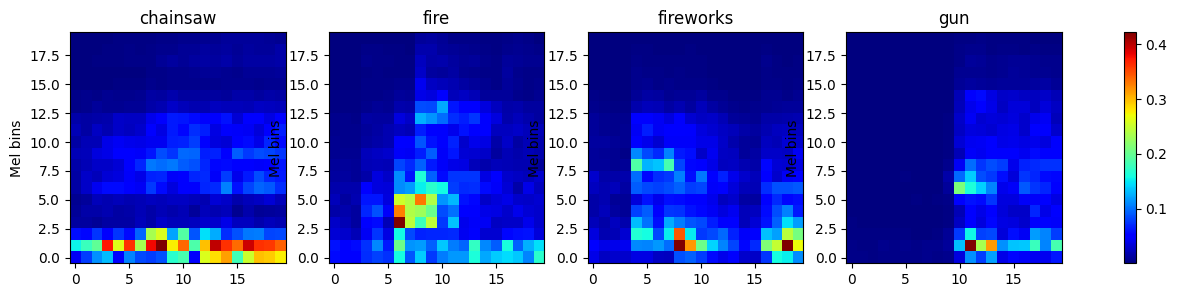

time_shift
add_bg
physical_bg
../datasets/melvecs/augmented/melvecs_512_20_1050_1200_time_shift_5_add_bg_6_physical_bg
Number of shifts:  5
Number of bg_amplitude_limit and values:  6 [0.316, 0.5, 1, 1.5, 2, 3]
Physical augmentation:  True
X_aug shape:  (5920, 400)
Augmenting with time_shift
Shift number:  1
Shift percentage:  0.46188051601915037
0/120
1/120
2/120
3/120
4/120
5/120
6/120
7/120
8/120
9/120
10/120
11/120
12/120
13/120
14/120
15/120
16/120
17/120
18/120
19/120
20/120
21/120
22/120
23/120
24/120
25/120
26/120
27/120
28/120
29/120
30/120
31/120
32/120
33/120
34/120
35/120
36/120
37/120
38/120
39/120
40/120
41/120
42/120
43/120
44/120
45/120
46/120
47/120
48/120
49/120
50/120
51/120
52/120
53/120
54/120
55/120
56/120
57/120
58/120
59/120
60/120
61/120
62/120
63/120
64/120
65/120
66/120
67/120
68/120
69/120
70/120
71/120
72/120
73/120
74/120
75/120
76/120
77/120
78/120
79/120
80/120
81/120
82/120
83/120
84/120
85/120
86/120
87/120
88/120
89/120
90/120
91/120
92/120
93/120
94/

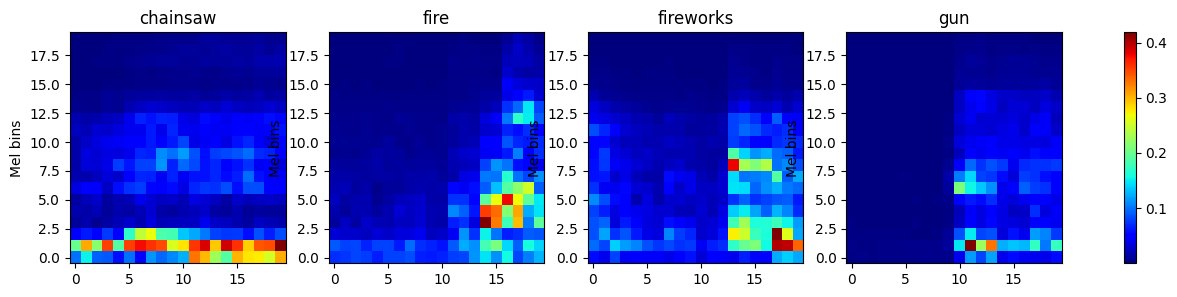

Plotting index: 490 (Aug: 1, Class: chainsaw, Img: 10)
Plotting index: 610 (Aug: 1, Class: fire, Img: 10)
Plotting index: 730 (Aug: 1, Class: fireworks, Img: 10)
Plotting index: 850 (Aug: 1, Class: gun, Img: 10)


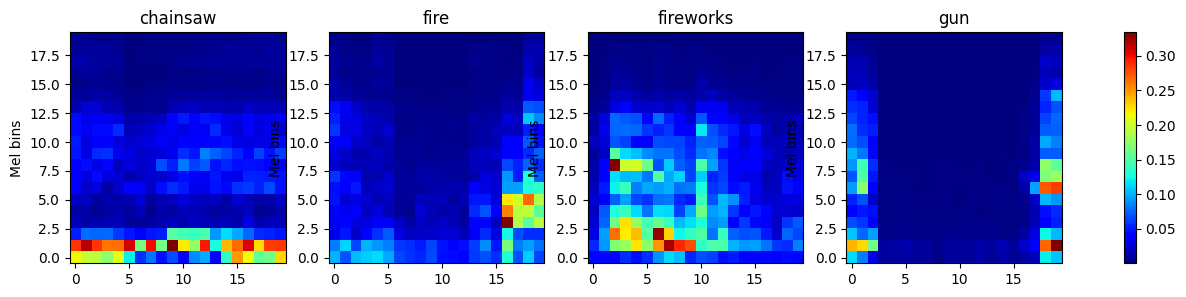

Plotting index: 970 (Aug: 2, Class: chainsaw, Img: 10)
Plotting index: 1090 (Aug: 2, Class: fire, Img: 10)
Plotting index: 1210 (Aug: 2, Class: fireworks, Img: 10)
Plotting index: 1330 (Aug: 2, Class: gun, Img: 10)


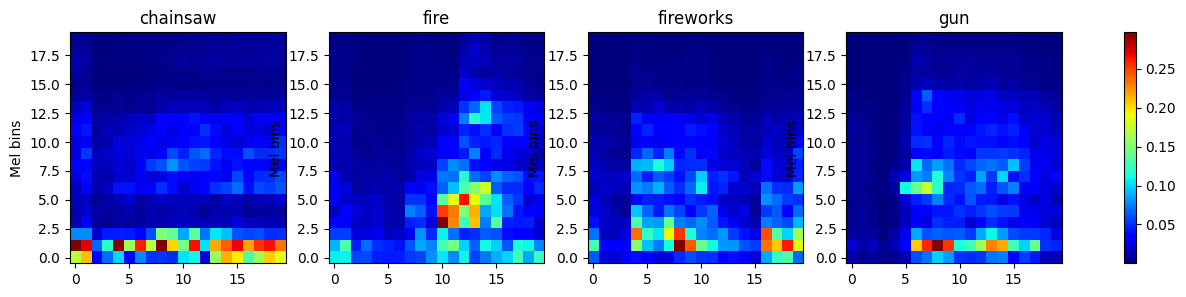

Plotting index: 1450 (Aug: 3, Class: chainsaw, Img: 10)
Plotting index: 1570 (Aug: 3, Class: fire, Img: 10)
Plotting index: 1690 (Aug: 3, Class: fireworks, Img: 10)
Plotting index: 1810 (Aug: 3, Class: gun, Img: 10)


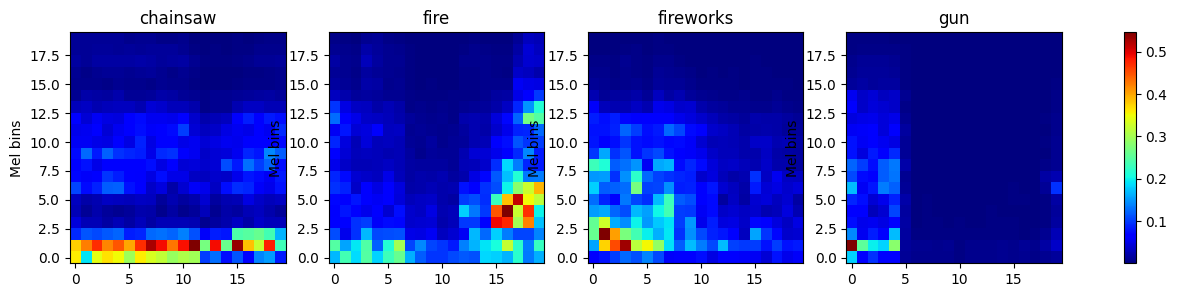

Plotting index: 1930 (Aug: 4, Class: chainsaw, Img: 10)
Plotting index: 2050 (Aug: 4, Class: fire, Img: 10)
Plotting index: 2170 (Aug: 4, Class: fireworks, Img: 10)
Plotting index: 2290 (Aug: 4, Class: gun, Img: 10)


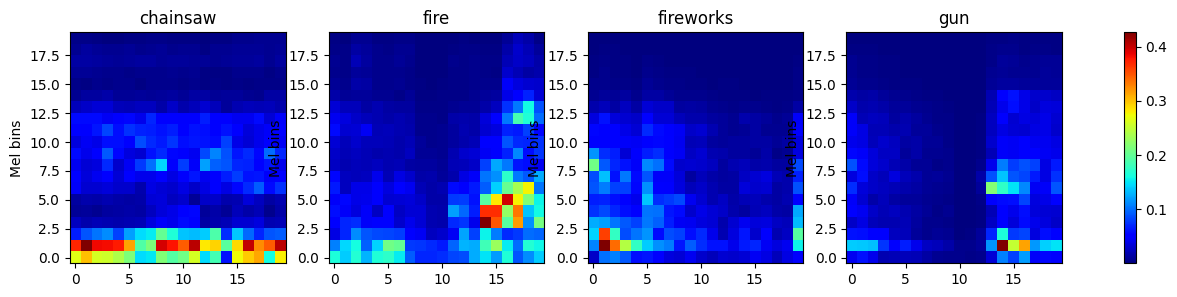

Plotting index: 2410 (Aug: 5, Class: chainsaw, Img: 10)
Plotting index: 2530 (Aug: 5, Class: fire, Img: 10)
Plotting index: 2650 (Aug: 5, Class: fireworks, Img: 10)
Plotting index: 2770 (Aug: 5, Class: gun, Img: 10)


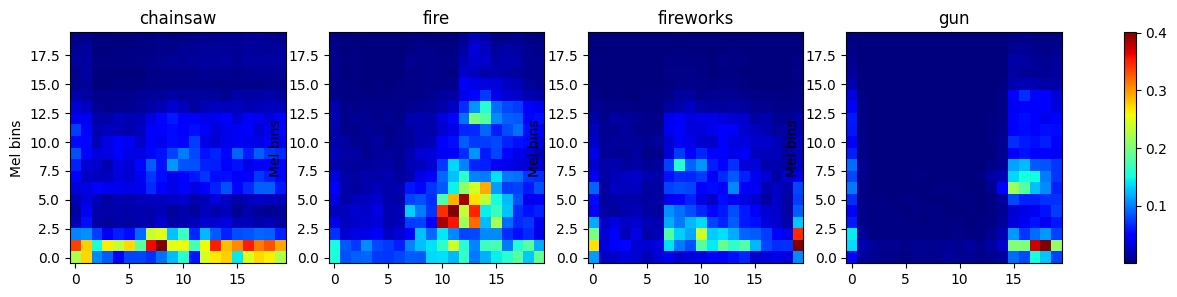

Plotting index: 2890 (Aug: 6, Class: chainsaw, Img: 10)
Plotting index: 3010 (Aug: 6, Class: fire, Img: 10)
Plotting index: 3130 (Aug: 6, Class: fireworks, Img: 10)
Plotting index: 3250 (Aug: 6, Class: gun, Img: 10)


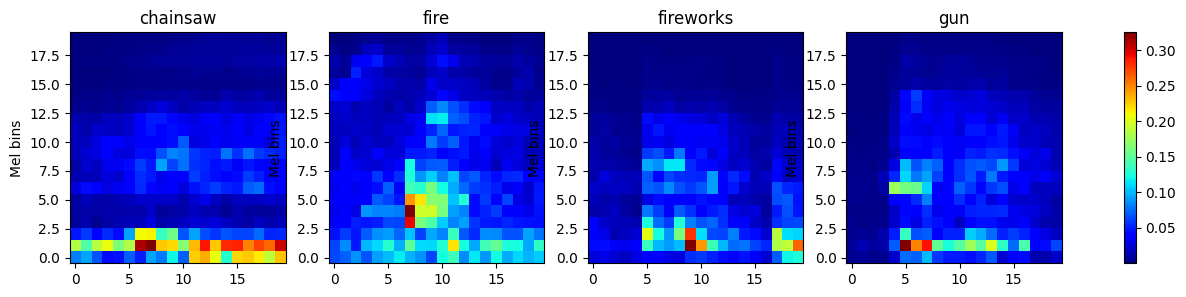

Plotting index: 3370 (Aug: 7, Class: chainsaw, Img: 10)
Plotting index: 3490 (Aug: 7, Class: fire, Img: 10)
Plotting index: 3610 (Aug: 7, Class: fireworks, Img: 10)
Plotting index: 3730 (Aug: 7, Class: gun, Img: 10)


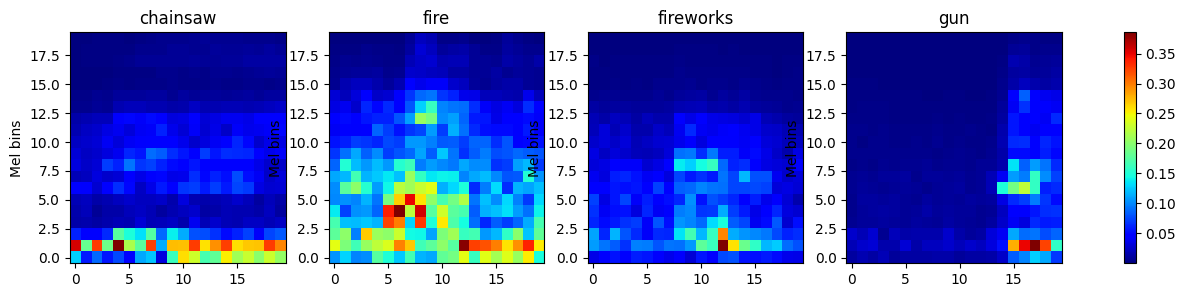

Plotting index: 3850 (Aug: 8, Class: chainsaw, Img: 10)
Plotting index: 3970 (Aug: 8, Class: fire, Img: 10)
Plotting index: 4090 (Aug: 8, Class: fireworks, Img: 10)
Plotting index: 4210 (Aug: 8, Class: gun, Img: 10)


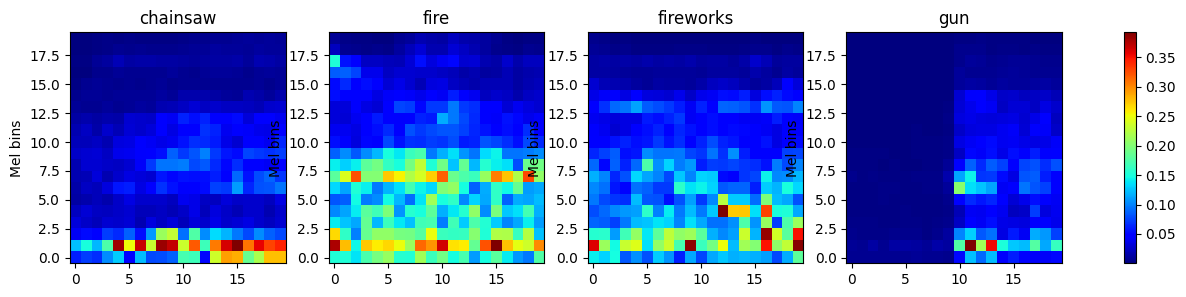

Plotting index: 4330 (Aug: 9, Class: chainsaw, Img: 10)
Plotting index: 4450 (Aug: 9, Class: fire, Img: 10)
Plotting index: 4570 (Aug: 9, Class: fireworks, Img: 10)
Plotting index: 4690 (Aug: 9, Class: gun, Img: 10)


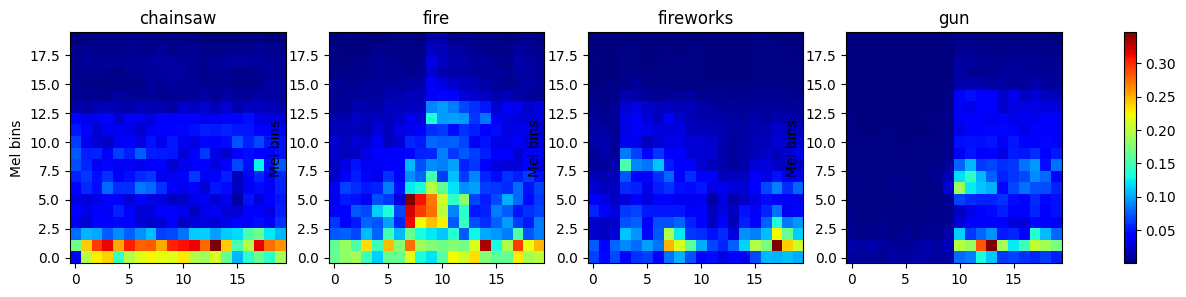

Plotting index: 4810 (Aug: 10, Class: chainsaw, Img: 10)
Plotting index: 4930 (Aug: 10, Class: fire, Img: 10)
Plotting index: 5050 (Aug: 10, Class: fireworks, Img: 10)
Plotting index: 5170 (Aug: 10, Class: gun, Img: 10)


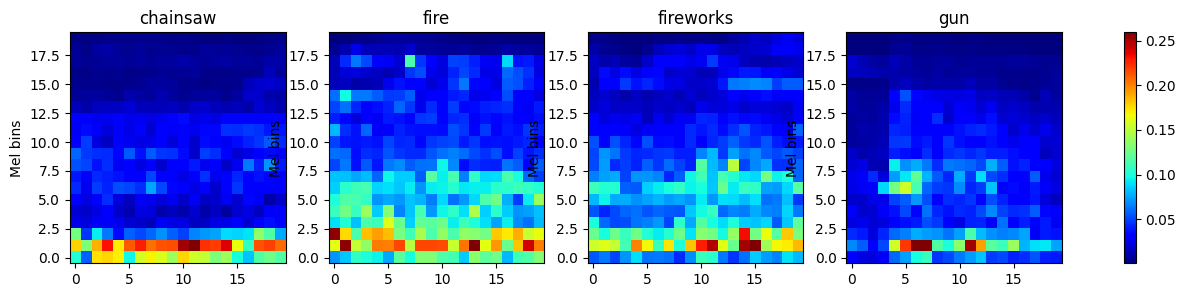

In [ ]:
#TODO: TO IMPROVE: data augmentation
#Idea: concatenate all sounds of the same class, and create much more instances by using shift
## + Sound analysis: if soud not loud enough, set its label to "garbage"
## Also garbage if only noise / ambiant sound

#Physical HP
Nft = 512
nmel = 20
#1050 pour MCU!
duration = 1050
fs = 1200

#Visualisation
img_idx = 10


#1. Import classical dataset
myds, dataset, classnames = get_dataset(path="../datasets/sounds/recorded_sounds/classes/", filter_str=None, #"_1_"
    Nft=Nft, nmel=nmel, duration=duration, fs= fs, normalize=True, shift_pct=0, verbose=True, img_idx = img_idx, play_sound=True)

#3. Dataset augmentations - TO UPDATE
# original - 2 shifts - 1 bg: 16min
# original - 4 shifts - 1 bg: 26min


#CAREFUL: always respect the order
augmentations = ["time_shift","add_bg", "physical_bg"]
#augmentations = ["add_bg"]

shift_nb = 5 if "time_shift" in augmentations else 0
bg_amplitude_limit = [0.316, 0.5, 1, 1.5, 2, 3] if "add_bg" in augmentations else []      #0.1: 20dB, 0.316: 5dB
physical_aug = ("physical_bg" in augmentations)

#define a pickle name corresponding to the number of shifts and background noises and length
#pickle_name = f"../datasets/melvecs/recorded_{shift_nb}_shifts_{len(bg_amplitude_limit)}_backgrounds_physical_{'physical_bg' in augmentations}_{duration/1000}.npy"
pickle_name = get_picklename(Nft,nmel,duration,fs, augmentations, shift_nb, bg_amplitude_limit, physical_aug= physical_aug, prefix= "../datasets/melvecs/")
print(pickle_name)

# NORMALEMENT, la data augmentation doit être faite APRES le split train/test, mais demande de changer tt le code
#NEW: function spectro_aug_timefreq_masking - TODO

if "add_bg" in augmentations:
    bg_dataset = Dataset(folder="../datasets/sounds/recorded_sounds/background/", filter_str=None)
else :
    bg_dataset = None

if "physical_bg" in augmentations:
    my_phy_ds, phy_bg_dataset, classnames = get_dataset(path="../datasets/sounds/recorded_sounds/classes/", filter_str="_background_",
        Nft=Nft, nmel=nmel, duration=duration, fs = fs, normalize=True, shift_pct=0, verbose=False, img_idx = img_idx, play_sound=False)
else :
    my_phy_ds = None
    phy_bg_dataset = None


load_matrix = False

 #Visualisation purposes
verbose = True
play_sound = False
plot_indexes = [0,1,2,3,4,5,6,7,8,9,10]


X, y = augment_dataset(myds, dataset, classnames, augmentations, duration=duration,
                       shift_nb = shift_nb, #numbers of shifts done
                       bg_dataset = bg_dataset, bg_amplitude_limit=bg_amplitude_limit, #dataset used for background noise, background amplitudes
                       physical_bg_dataset = phy_bg_dataset,my_phy_ds = my_phy_ds, #dataset used for physical background noises
                       verbose=verbose, img_idx=img_idx, aug_indexes=plot_indexes, play_sound=play_sound, #verbose parameters
                       load_matrix=load_matrix, pickle_name=pickle_name) #load and save parameters
                       
# Transform the labels to integers and save mapping
label_to_id = {label: i for i, label in enumerate(classnames)}
id_to_label = {i: label for label, i in label_to_id.items()}
y = np.array([label_to_id[label] for label in y])



In [ ]:

#TODO: IMPROVE THE FUNCTION SO THAT IT TAKES X, Y AS INPUTS
def augment_dataset(myds, dataset, classnames, augmentations, nmel=20,  duration=950,
                    bg_dataset = None, bg_amplitude_limit=[0.1], physical_bg_dataset = None, my_phy_ds = None, shift_nb = 1, 
                    load_matrix = False, verbose=False, img_idx=0, aug_indexes = [0], play_sound=False,pickle_name = "feature_matrix_2D_aug.npy"):
    """
    Augment dataset and compute feature matrix.
    """
    train_pct = 1
    featveclen = len(myds["gun", 0])  # Number of items in a feature vector
    nitems = len(myds)  # Number of sounds in dataset
    naudio = dataset.naudio  # Number of audio files per class
    nclass = dataset.nclass  # Number of classes
    nlearn = round(naudio * train_pct)  # Training sample count

    myds.data_aug = None  # Ensure no augmentation initially
    data_aug_factor = len(augmentations)
    myds.data_aug_factor = data_aug_factor
    #myds.mod_data_aug(augmentations)


    
    myds.bg_dataset = bg_dataset
    myds.bg_amplitude_limit = bg_amplitude_limit
    myds.duration = duration


    if load_matrix:
        X_aug = np.load(pickle_name +'.npy', allow_pickle=True)
        #for y_aug, remove the .npy extension from the pickle name and add ".labels.npy"
        y_aug = np.load(pickle_name + ".labels.npy", allow_pickle=True)
    else:
        nb_phi = 1 if "physical_bg" in augmentations else 0
        start_time = time.time()
        X_aug = np.zeros((nclass * naudio  + shift_nb * nclass * naudio +  len(bg_amplitude_limit) * nclass * naudio + nb_phi * nclass * 40, featveclen))
        y_aug = np.empty((nclass * naudio  + shift_nb * nclass * naudio +  len(bg_amplitude_limit) * nclass * naudio + nb_phi * nclass * 40,), dtype=object)
        print("Number of shifts: ", shift_nb)
        print("Number of bg_amplitude_limit and values: ", len(bg_amplitude_limit), bg_amplitude_limit)
        print("Physical augmentation: ", "physical_bg" in augmentations)
        print("X_aug shape: ", X_aug.shape)

        #original dataset
        for idx in range(naudio):
            for class_idx, classname in enumerate(classnames):
                try:
                    featvec = myds[classname, idx]
                    X_aug[class_idx * naudio + idx, :] = featvec
                    y_aug[class_idx * naudio + idx] = classname
                except:
                    print(f"Error at {classname}, {idx}")
                    continue
        
        
        # Individual augmentations
        if len(augmentations) != 0:
            for current_aug in augmentations:
                myds.data_aug = current_aug
                print(f"Augmenting with {current_aug}")

                if current_aug == "time_shift":
                    myds.data_aug = "time_shift"

                    for j in range(0,shift_nb):
                        print("Shift number: ", j+1)
                        myds.shift_pct = np.random.uniform(0, 1)
                        print("Shift percentage: ", myds.shift_pct)                        
                        for idx in range(dataset.naudio):
                            print(f"%d/%d" % (idx, dataset.naudio))
                            for class_idx, classname in enumerate(classnames):
                                #print(classname, idx)
                                featvec = myds[classname, idx]
                                #print((s+1) * nclass * naudio + j * nclass * naudio + class_idx * naudio + idx)
                                X_aug[nclass * naudio + j * nclass * naudio + class_idx * naudio + idx, :] = featvec
                                y_aug[nclass * naudio + j * nclass * naudio + class_idx * naudio + idx] = classname

                elif current_aug == "add_bg":
                    myds.data_aug = "add_bg"

                    for j in range(0,len(bg_amplitude_limit)):
                        print("Background number: ", j)
                        myds.bg_amplitude_limit = bg_amplitude_limit[j]
                        for idx in range(dataset.naudio):
                            print(f"%d/%d" % (idx, dataset.naudio))
                            for class_idx, classname in enumerate(classnames):
                                sound_name = dataset.__getname__((classname, img_idx))  # Retrieve sound name
                                # Skip processing if "background" is in the filename
                                if "background" in sound_name.lower():  
                                    continue 
                                #print(classname, idx)
                                featvec = myds[classname, idx]
                                #print(nclass * naudio + shift_nb * nclass * naudio + j * naudio * nclass + class_idx * naudio + idx)
                                X_aug[nclass * naudio + shift_nb * nclass * naudio + j * naudio * nclass + class_idx * naudio + idx, :] = featvec
                                y_aug[nclass * naudio + shift_nb * nclass * naudio + j * naudio * nclass+ class_idx * naudio + idx] = classname
                
                elif current_aug == "physical_bg":
                    if physical_bg_dataset is not None:
                        for idx in range(physical_bg_dataset.naudio):
                            for class_idx, classname in enumerate(classnames):
                                featvec = my_phy_ds[classname, idx]
                                #print(nclass * naudio + shift_nb * nclass * naudio + len(bg_amplitude_limit) * naudio * nclass + class_idx* 40 + idx)
                                X_aug[nclass * naudio + shift_nb * nclass * naudio + len(bg_amplitude_limit) * naudio * nclass + class_idx
                                        * 40 + idx, :] = featvec
                                y_aug[nclass * naudio + shift_nb * nclass * naudio + len(bg_amplitude_limit) * naudio * nclass + class_idx
                                        * 40 + idx] = classname
                else:
                    print("ERROR - Wrong augmentation name!")

                        
        # Combined augmentations - TODO if necessary

        #X_aug = X_aug / np.linalg.norm(X_aug, axis=1, keepdims=True)  # Normalize - already done
        
        np.save(pickle_name, X_aug, allow_pickle=True)
        np.save(pickle_name + "labels", y_aug, allow_pickle=True)
        end_time = time.time()
        #print the time in minutes
        print("Time taken to augment the dataset: ", (end_time - start_time)/60, " minutes")
    if verbose:
        print(f"Shape of feature matrix: {X_aug.shape}")
        print(f"Number of labels: {len(y_aug)}")

        for aug_idx in aug_indexes:
            fig, axs = plt.subplots(1, len(classnames), figsize=(len(classnames) * 4, 3))
        
            for class_idx, ax in enumerate(axs):
                # Compute the correct index based on augmentation type
                if aug_idx == 0:
                    # Original dataset
                    data_index = class_idx * naudio + img_idx
                elif 1 <= aug_idx <= shift_nb:
                    # Time shift augmentations
                    shift_offset = nclass * naudio
                    data_index = shift_offset + (aug_idx - 1) * nclass * naudio + class_idx * naudio + img_idx
                elif shift_nb < aug_idx <= shift_nb + len(bg_amplitude_limit):
                    # Background noise augmentations
                    bg_offset = (1 + shift_nb) * nclass * naudio
                    bg_idx = aug_idx - (shift_nb + 1)
                    data_index = bg_offset + bg_idx * nclass * naudio + class_idx * naudio + img_idx
                elif aug_idx > shift_nb + len(bg_amplitude_limit):
                    # Physical augmentation
                    phys_offset = (1 + shift_nb + len(bg_amplitude_limit)) * nclass * naudio
                    phys_idx = aug_idx - (shift_nb + len(bg_amplitude_limit) + 1)
                    data_index = phys_offset + phys_idx * nclass * 40 + class_idx * 40 + img_idx
                else:
                    print(f"Skipping invalid aug_idx {aug_idx}")
                    continue


                # Ensure index is within bounds
                if data_index >= X_aug.shape[0]:
                    print(f"Skipping aug_idx {aug_idx}, class_idx {class_idx}, img_idx {img_idx}: Index out of bounds.")
                    continue

                print(f"Plotting index: {data_index} (Aug: {aug_idx}, Class: {classnames[class_idx]}, Img: {img_idx})")

                # Plot the spectrogram/mel features
                ax.imshow(
                    X_aug[data_index].reshape((nmel, -1)), 
                    cmap="jet",
                    origin="lower",
                    aspect="auto",
                )
                ax.set_title(classnames[class_idx])
                ax.set_xlabel("")
                ax.set_ylabel("Mel bins")

            # Add colorbar
            plt.colorbar(axs[-1].images[0], ax=axs, orientation='vertical')
            plt.show()
                

    
    return X_aug, y_aug

### 2. Data split

In [40]:
"""
naudio = dataset.naudio  # Number of audio files per class
nclass = dataset.nclass  # Number of classes

#Get the original X,y dataset: from index 0 to index nclasses * naudio to ensure that the test set is only taken from the original dataset
#Quand même du leakage !! Car j'utilise les audios de mon test set pour l'augmentation! Solution intermédiaire
X_original = X[0:nclass * naudio]
y_original = y[0:nclass * naudio]

X_augmented = X[nclass * naudio:]
y_augmented = y[nclass * naudio:]

#If physical augmentation, add the augmented data to the original dataset
if "physical_bg" in augmentations:
    X_physical = X[nclass * naudio + shift_nb * nclass * naudio + len(bg_amplitude_limit) * nclass * naudio:]
    y_physical = y[nclass * naudio + shift_nb * nclass * naudio + len(bg_amplitude_limit) * nclass * naudio:]
    X_original = np.concatenate((X_original, X_physical), axis=0)
    y_original = np.concatenate((y_original, y_physical), axis=0)

    X_augmented = X[nclass * naudio:nclass * naudio + shift_nb * nclass * naudio + len(bg_amplitude_limit) * nclass * naudio]
    y_augmented = y[nclass * naudio:nclass * naudio + shift_nb * nclass * naudio + len(bg_amplitude_limit) * nclass * naudio]

#Get the augmented dataset: from index nclasses * naudio to the end

#Erronous: the data split should be done before data augmentation! 
X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.3, random_state=42, stratify=y_original)

#Add the augmented data to the training set
X_train = np.concatenate((X_train, X_augmented), axis=0)
y_train = np.concatenate((y_train, y_augmented), axis=0)

#Assert that the X_test and y_test set can only be taken from the original dataset: unitl len(nclasses) * naudio, no more
#assert(len(y_test) <= len(classnames) * dataset.naudio)
"""

#Before solving the data leakage problem, I'll only use the physically augmented data for the training set
naudio = dataset.naudio  # Number of audio files per class
nclass = dataset.nclass  # Number of classes

X_train = X[0:nclass * naudio + shift_nb * nclass * naudio + len(bg_amplitude_limit) * nclass * naudio]
y_train = y[0:nclass * naudio + shift_nb * nclass * naudio + len(bg_amplitude_limit) * nclass * naudio]

X_test = X[nclass * naudio + shift_nb * nclass * naudio + len(bg_amplitude_limit) * nclass * naudio:]
y_test = y[nclass * naudio + shift_nb * nclass * naudio + len(bg_amplitude_limit) * nclass * naudio:]

if (verbose):
    print(f"Shape of the training matrix : {X_train.shape}")
    print(f"Number of training labels : {len(y_train)}")
    
    print(f"Shape of the test matrix : {X_test.shape}")
    print(f"Number of test labels : {len(y_test)}")


Shape of the training matrix : (5760, 400)
Number of training labels : 5760
Shape of the test matrix : (160, 400)
Number of test labels : 160


### 3. Data preparation
Find if smthg to do here

### 5. Modelling

In [41]:


#A. HyperResNet
hyperResNet = HyperResNet(input_shape=X_train.shape[1:], classes=4)

#B. HyperEfficientNet
hyperEfficientNet = HyperEfficientNet(input_shape=X_train.shape[1:], classes=4)

#C. HyperXception
hyperXception = HyperXception(input_shape=X_train.shape[1:], classes=4)


#D Self-made 1
def self_made_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape = X_train.shape[1:]))

    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=512, step=32)
    hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=512, step=32)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) 

    model.add(tf.keras.layers.Dense(units=hp_layer_1 , activation=hp_activation))
    model.add(tf.keras.layers.Dense(units=hp_layer_2 , activation=hp_activation))
    model.add(tf.keras.layers.Dense(4, activation='softmax'))

    # ⚠️ Always create a fresh optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.01]))

    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model



### 6. Training & 7. Evaluation

In [42]:
import keras_tuner as kt

tf.config.run_functions_eagerly(True)  # Force eager execution

from tensorflow.keras.utils import to_categorical

import pandas as pd
X_train = np.array(X_train, dtype=np.float32)
X_train = pd.DataFrame(X_train).apply(pd.to_numeric, errors='coerce')
X_train = X_train.fillna(0).values
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Convert labels to numbers

def create_tuner(hypermodel):
    return kt.Hyperband(self_made_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hp_dir',
                     project_name='tuner1')


#(A: HyperResNet, B: HyperEfficientNet, C: HyperXception, D: self_made_builder)
tuner = create_tuner(hyperXception)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Reloading Tuner from hp_dir/tuner1/tuner0.json


In [43]:
from seaborn import heatmap

def show_confusion_matrix(y_predict, y_true, classnames, title=""):
    """
    From target labels and prediction arrays, sort them appropriately and plot confusion matrix.
    The arrays can contain either ints or str quantities, as long as classnames contains all the elements present in them.
    """
    plt.figure(figsize=(6, 6))  # Enlarged the figure size for better visibility
    
    # Compute confusion matrix
    confmat = confusion_matrix(y_true, y_predict)
    
    # Plot confusion matrix with enlarged annotations
    heatmap(
        confmat.T,
        square=True,
        annot=True,
        fmt="d",
        cbar=False,
        xticklabels=classnames,
        yticklabels=classnames,
        annot_kws={"size": 14},  # Increase font size for annotations
        ax=plt.gca(),
    )
    
    # Set larger font sizes for labels and title
    plt.xlabel("True label", fontsize=16)
    plt.ylabel("Predicted label", fontsize=16)
    plt.title(title, fontsize=18)
    
    # Enlarge tick labels
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    
    # Display the plot
    plt.show()
    return None

def perform_kfold(model, X, y, k=5, epochs=5, batch_size=32):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracy_scores, recall_scores, f1_scores = [], [], []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        
        y_pred = np.argmax(model.predict(X_val), axis=1)
        y_true = y_val if len(y_val.shape) == 1 else np.argmax(y_val, axis=1)
        
        report = classification_report(y_true, y_pred, output_dict=True)
        accuracy_scores.append(report['accuracy'])
        recall_scores.append(report['macro avg']['recall'])
        f1_scores.append(report['macro avg']['f1-score'])
    
    print(f"Mean Accuracy: {np.mean(accuracy_scores):.5f}")
    print(f"Mean Recall: {np.mean(recall_scores):.5f}")
    print(f"Mean F1-score: {np.mean(f1_scores):.5f}")

def evaluate_model(model, X_train, y_train, X_test, y_test, classnames):
    model.fit(X_train, y_train, epochs=5, validation_split=0.2, verbose=1)
    
    y_pred_train = np.argmax(model.predict(X_train), axis=1)
    y_pred_test = np.argmax(model.predict(X_test), axis=1)
    y_true_train = y_train if len(y_train.shape) == 1 else np.argmax(y_train, axis=1)
    y_true_test = y_test if len(y_test.shape) == 1 else np.argmax(y_test, axis=1)
    
    print("Training results:\n---------------------")
    print(f"Accuracy on train set: {np.mean(y_pred_train == y_true_train):.5f}")
    print(f"Accuracy on test set: {np.mean(y_pred_test == y_true_test):.5f}")
    
    print("Confusion Matrix (Train):")
    show_confusion_matrix(y_pred_train, y_true_train, classnames, title="Confusion Matrix - Train")
    print("Confusion Matrix (Test):")
    show_confusion_matrix(y_pred_test, y_true_test, classnames, title="Confusion Matrix - Test")
    
    print("\nClassification Report:")
    print(classification_report(y_true_test, y_pred_test, target_names=classnames))


### 8. Final model

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
model_name = get_picklename(Nft,nmel,duration,fs, augmentations, shift_nb, bg_amplitude_limit, physical_aug= physical_aug, prefix= "model_")


#8. Final_model
#TODO: perform_KFold, fit, predict, accuracy, confusion_matrix, classification_report

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)


predictions = hypermodel.predict(X_test)

eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

# Perform K-Fold cross-validation
perform_kfold(model, X_train, y_train, k=5, epochs=5)

# Train and evaluate final model
evaluate_model(model, X_train, y_train, X_test, y_test, classnames)


#Set a file name including the 
#model_name = f"../datasets/melvecs/recorded_{shift_nb}_shifts_{len(bg_amplitude_limit)}_backgrounds_physical_{'physical_bg' in augmentations}_{duration/1000}s.h5"
model.save('../../models/'+model_name+'.h5')  # Saves in HDF5 format

time_shift
add_bg
physical_bg
Epoch 1/10


/home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.5692 - loss: 1.0065 - val_accuracy: 0.5217 - val_loss: 1.2158
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8152 - loss: 0.4783 - val_accuracy: 0.6267 - val_loss: 1.0436
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8603 - loss: 0.3684 - val_accuracy: 0.6936 - val_loss: 0.8538
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9167 - loss: 0.2333 - val_accuracy: 0.6788 - val_loss: 1.0749
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9346 - loss: 0.1833 - val_accuracy: 0.6667 - val_loss: 1.1151
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9430 - loss: 0.1475 - val_accuracy: 0.7205 - val_loss: 1.0527
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9585 - loss: 0.1107 - val_accuracy: 0.7604 - val_loss: 0.7845
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9681 - loss: 0.0958 - val_accurac